XGBoost model for predicting filtered shear stress

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
import h5py
import time

In [2]:
## Function to create data history
# n_steps = 300 = 3s history
# Features (history): n-300, n-299, ... , n-2, n-1 
# Traget variable: n

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [3]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()}) 
df1 = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3787:136186].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3787:136186].ravel(),
                    'freqQAmpI_filt_pc':data2['freqQAmpI_filt_pc'].ravel()})

df = pd.concat([df1, df2], axis=1)

df = df[['freqQAmpI_filt', 'freqQAmpI_filt_pc', 'V_filt', 'Vel_pc', 'maxFreqI_filt', 'SS']]
print("Input data:\n", df)


Input data:
         freqQAmpI_filt  freqQAmpI_filt_pc  ...  maxFreqI_filt        SS
0         31438.277060                0.0  ...  457680.400524  5.656166
1         31421.341616                0.0  ...  457727.638932  5.657157
2         31409.798761                0.0  ...  457770.778724  5.658317
3         31398.815589                0.0  ...  457811.889181  5.659499
4         31395.584981                0.0  ...  457775.514596  5.660404
...                ...                ...  ...            ...       ...
132394    31041.955345                0.0  ...  454414.128118  5.471059
132395    31035.059531                0.0  ...  454404.028108  5.474545
132396    31020.001291                0.0  ...  454403.709700  5.478286
132397    31012.016780                0.0  ...  454398.871858  5.481751
132398    31010.874482                0.0  ...  454410.333590  5.484813

[132399 rows x 6 columns]


In [4]:
# Preprocessing

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D 

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 5)
Target shape, Y =  (132099,)
After reshaping, X =  (132099, 1500)


In [5]:
# Split into train-val-test

x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)   
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)
print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95111, 1500)
Validation: (10568, 1500)
Testing: (26420, 1500)


In [ ]:
# Parameter tuning

params = {
        'learning_rate': [0.01, 0.1, 0.5],
        'n_estimators': [200, 600, 1000],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7, 9],
        'objective':['reg:squarederror']
        }

best_score = 0

for g in ParameterGrid(params):
  model = XGBRegressor()
  model.set_params(**g)
  model.fit(X_train, Y_train)
  y_predVal = model.predict(X_val)
  val_r2 = r2_score(Y_val, y_predVal)
  if val_r2 > best_score:
    best_score = val_r2
    best_grid = g
#print(best_grid)


In [7]:
# Train the model

#model = XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=600, objective='reg:squarederror')
model = XGBRegressor()
model.set_params(**best_grid)
start_time = time.time()
model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], verbose=False, early_stopping_rounds = 40)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

---Training time: 1162.29938722 seconds ---


In [8]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)
print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))


R^2 scores:  0.9679134137331311 0.9558979022786727 0.9049739352249458
RMSE:  0.02302663088927334 0.030986593132796256 0.04454203918032709

---Time for Test data prediction: 0.38198280 seconds ---


In [ ]:
# Save the predictions
'''
hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/res300/xgb_ss_300.h5', 'w')
hf.create_dataset('y_predTrain', data=y_predTrain)
hf.create_dataset('y_predVal', data=y_predVal)
hf.create_dataset('y_predTest', data=y_predTest)
hf.close()
'''


Text(0.5, 1.0, 'Shear Stress prediction using XGBoost model')

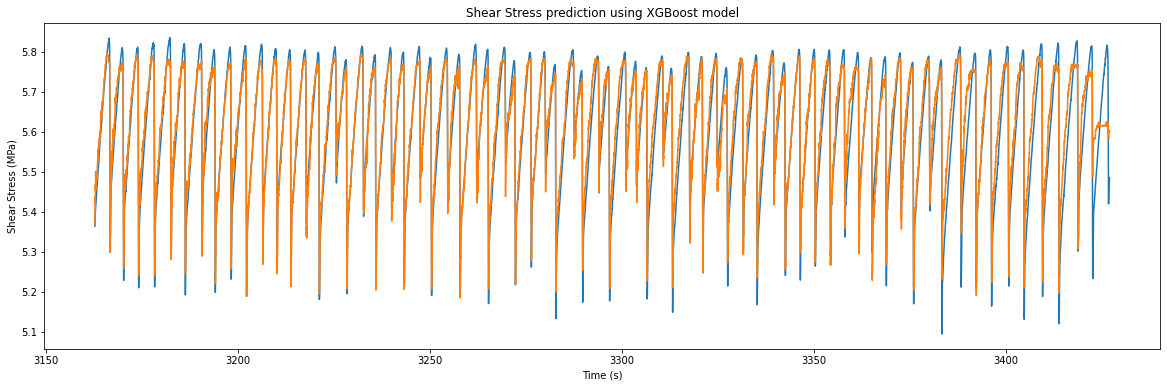

In [10]:
# Overall plot (test data)

ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(testtime, y_test)
#plt.plot(traintime, y_predTrain)
#plt.plot(valtime, y_predVal)
plt.plot(testtime, y_predTest)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
#plt.text(ttime.iloc[0], 5.3, 'Test R2 Score: %0.5f' %(test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
#plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Shear Stress prediction using XGBoost model')


Text(0.5, 1.0, 'Detailed View, Testing Data')

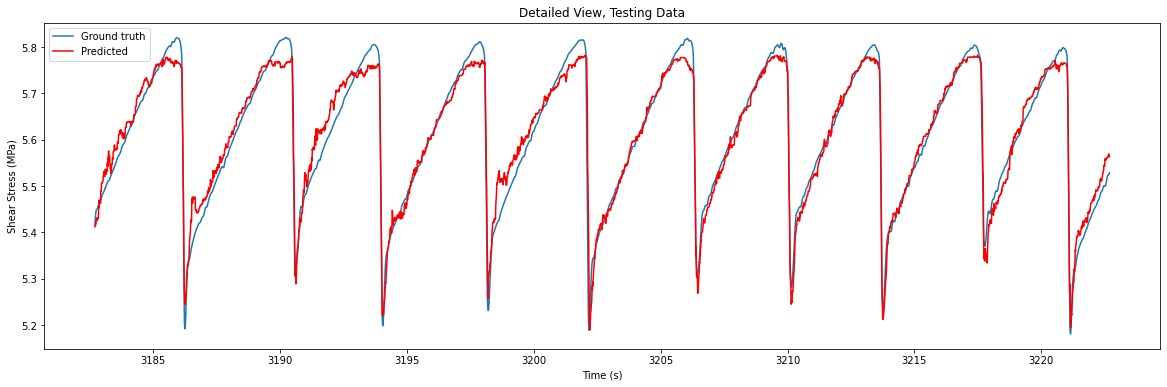

In [11]:
# Detailed test data plot

n = 4000
st_i = 2000
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


In [ ]:
'''
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,20
plot_tree(model, num_trees=230, rankdir='LR')
'''